In [5]:
import pandas as pd

In [6]:

# Load data
customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv('Transactions.csv')

In [7]:
# Merge datasets on 'CustomerID'
data = pd.merge(customers, transactions, on='CustomerID')

In [8]:
data = data.dropna()

In [9]:
customer_transactions = data.groupby('CustomerID').agg(
    total_spend=('TotalValue', 'sum'),
    num_transactions=('TransactionID', 'count'),
    avg_transaction_value=('TotalValue', 'mean'),
    first_signup_date=('SignupDate', 'min'),
    last_transaction_date=('TransactionDate', 'max')
).reset_index()

In [10]:
customer_transactions['first_signup_date'] = pd.to_datetime(customer_transactions['first_signup_date'])
customer_transactions['last_transaction_date'] = pd.to_datetime(customer_transactions['last_transaction_date'])


In [11]:
# Add recency feature (days since last transaction)
customer_transactions['days_since_last_purchase'] = (pd.to_datetime('today') - customer_transactions['last_transaction_date']).dt.days

# Feature for frequency of purchase (days between first and last transaction)
customer_transactions['purchase_frequency'] = (customer_transactions['last_transaction_date'] - customer_transactions['first_signup_date']).dt.days

# Display the features
customer_transactions.head()

,CustomerID,total_spend,num_transactions,avg_transaction_value,first_signup_date,last_transaction_date,days_since_last_purchase,purchase_frequency
0,C0001,3354.52,5,670.904,2022-07-10,2024-11-02 17:04:16,84,846
1,C0002,1862.74,4,465.685,2022-02-13,2024-12-03 01:41:41,54,1024
2,C0003,2725.38,4,681.345,2024-03-07,2024-08-24 18:54:04,154,170
3,C0004,5354.88,8,669.360,2022-10-09,2024-12-23 14:13:52,33,806
4,C0005,2034.24,3,678.080,2022-08-15,2024-11-04 00:30:22,83,812


In [12]:
from sklearn.preprocessing import StandardScaler

# Select features for clustering
features = ['total_spend', 'num_transactions', 'avg_transaction_value', 'days_since_last_purchase', 'purchase_frequency']

# Scale features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_transactions[features])

# Check the scaled data
scaled_features[:5]


array([[-0.06170143, -0.01145819, -0.07026341, -0.26778131,  1.17168912],
       [-0.87774353, -0.46749414, -0.93493297, -0.69182757,  1.70326825],
       [-0.40585722, -0.46749414, -0.02627131,  0.72165997, -0.84711701],
       [ 1.03254704,  1.35664965, -0.0767689 , -0.98865996,  1.05223314],
       [-0.78392861, -0.92353008, -0.04002806, -0.28191618,  1.07015153]])

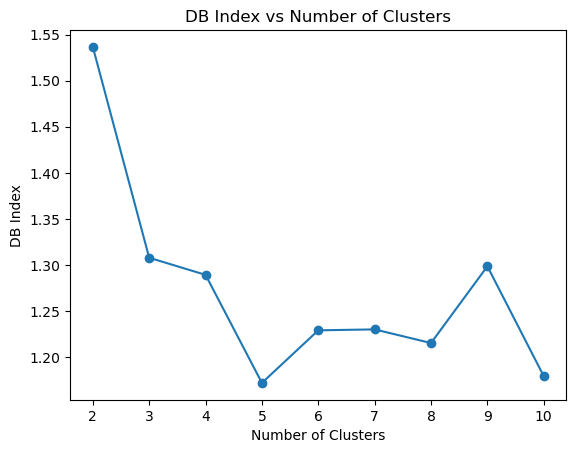

Optimal Number of Clusters: 5


In [13]:
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt

# Initialize a list to store DB Index for different number of clusters
db_indices = []

# Range of clusters to test (from 2 to 10)
cluster_range = range(2, 11)

# Loop over different k values
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters = kmeans.fit_predict(scaled_features)
    
    # Calculate DB Index for this clustering
    db_index = davies_bouldin_score(scaled_features, clusters)
    db_indices.append(db_index)

# Plot DB Index for different k values
plt.plot(cluster_range, db_indices, marker='o')
plt.title('DB Index vs Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('DB Index')
plt.show()

# Find the optimal number of clusters (the one with the lowest DB Index)
optimal_k = cluster_range[db_indices.index(min(db_indices))]
print(f'Optimal Number of Clusters: {optimal_k}')


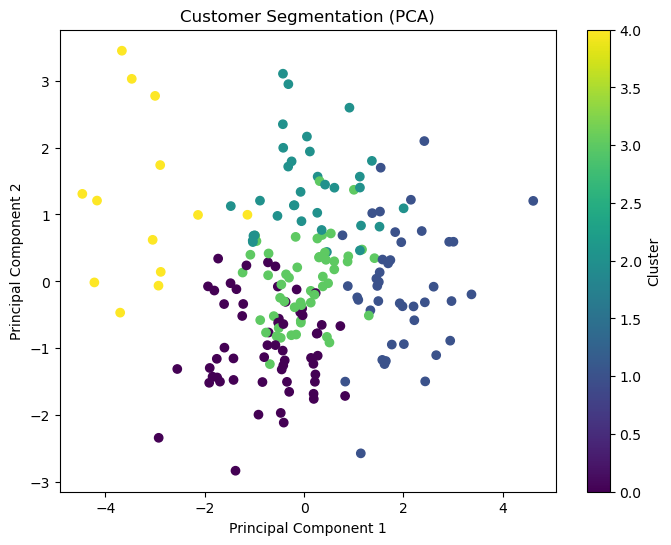

In [14]:
# Final clustering with optimal k
final_kmeans = KMeans(n_clusters=optimal_k, random_state=42)
final_clusters = final_kmeans.fit_predict(scaled_features)

# Add cluster labels to the dataframe
customer_transactions['Cluster'] = final_clusters

# Visualize clusters using PCA for dimensionality reduction
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_components = pca.fit_transform(scaled_features)

plt.figure(figsize=(8,6))
plt.scatter(pca_components[:, 0], pca_components[:, 1], c=final_clusters, cmap='viridis')
plt.title('Customer Segmentation (PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.show()


In [15]:
from sklearn.metrics import silhouette_score

# Calculate Silhouette Score
sil_score = silhouette_score(scaled_features, final_clusters)
print(f'Silhouette Score: {sil_score}')


Silhouette Score: 0.2490162366376269
